# Surrogate Gradient Tutorial

Welcome! This tutorial demonstrates the full power of Spyx: fully Just-In-Time compiled training to achieve incredible throughput! This notebook will demonstrate how you can train a spiking neural network on the Spiking Heidelberg Digits dataset in under a minute on any GPU!

In [1]:
import spyx
import spyx.nn as snn

# JAX imports
import os
import jax
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".80"
from jax import numpy as jnp
import jmp
import numpy as np

from jax_tqdm import scan_tqdm
from tqdm import tqdm

# implement our SNN in DeepMind's Haiku
import haiku as hk

# for surrogate loss training.
import optax

# rendering tools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
%matplotlib notebook

## Set Mixed Precision Policy

Since Spyx is built on top of Haiku, we can leverage the JAX Mixed Precision (JMP) library to automatically cast the numerical precision of different modules in our SNN. This allows us to have very granular control over the precision of different layers in the model (say, computing the linear layers in half precision but maintaining full precision for neuron state); the motivation for doing so is that NVIDIA's top-end GPU accelerators as well as Google's TPU use reduced numerical precision in order to achieve higher computational throughput, meaning our model can run faster with minimal losses in accuracy!

In [2]:
policy = jmp.get_policy('half')


hk.mixed_precision.set_policy(hk.Linear, policy)
hk.mixed_precision.set_policy(snn.LIF, policy)
hk.mixed_precision.set_policy(snn.LI, policy)
hk.mixed_precision.set_policy(spyx.axn.ActivityRegularization, policy)

## Data Loading

For the template, the Spiking Heidelberg Dataset is used. Feel free to replace this section with your own dataloading pipeline, just be sure once you've loaded and processed your whole dataset into RAM as a single numpy array and call np.packbits(data, axis=\<time axis\>) to compress the data prior to converting it to a jax.numpy array.

In [3]:
shd_dl = spyx.data.SHD_loader(256,128,128)

In [4]:
key = jax.random.PRNGKey(0)
x, y = shd_dl.train_epoch(key)

<IPython.core.display.Javascript object>


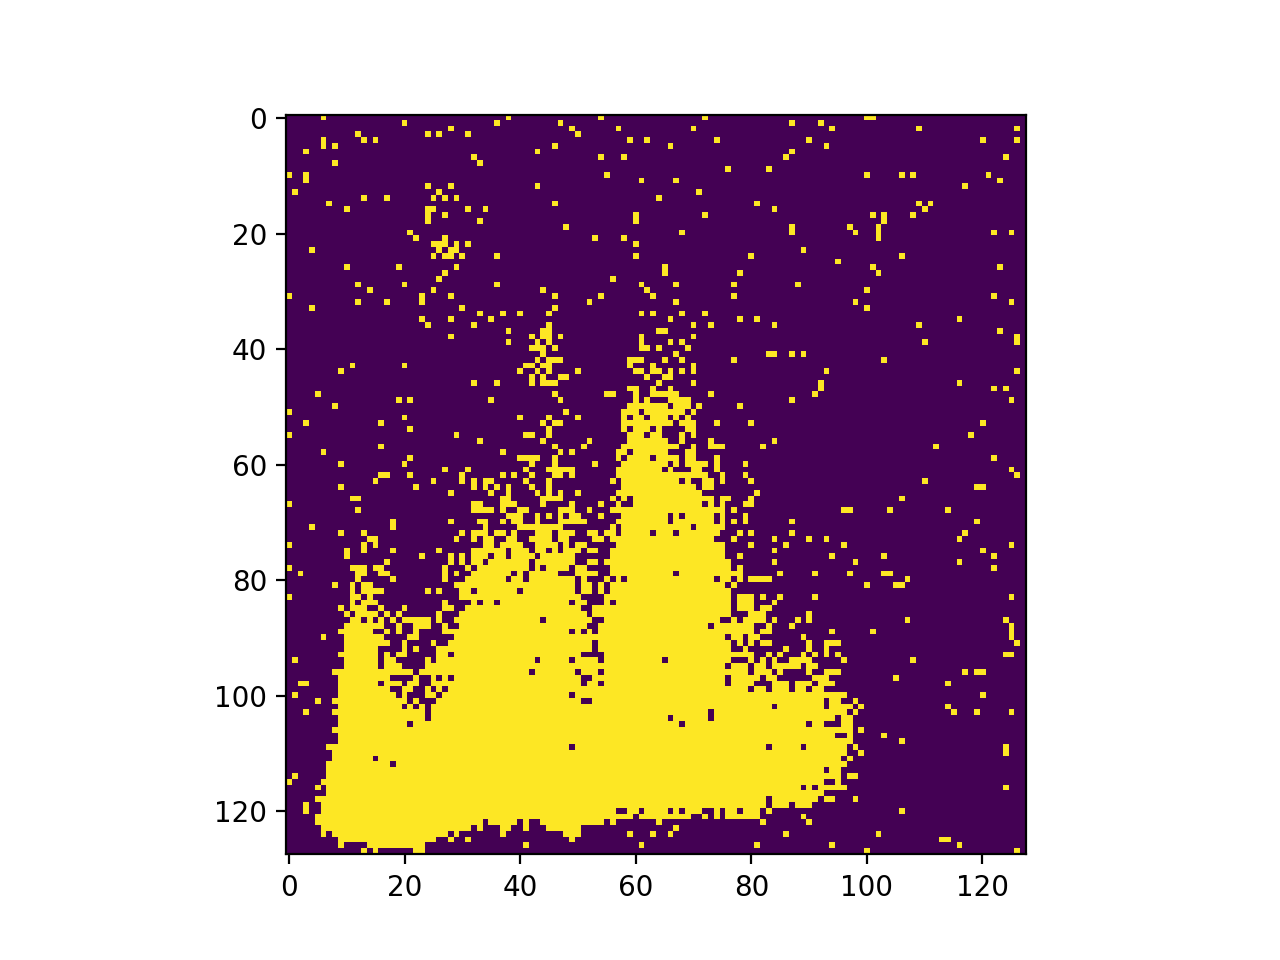

In [5]:
plt.imshow(np.unpackbits(x[0][69], axis=0).T)
plt.show()

In [6]:
y.shape

(25, 256)

## SNN

Here we define a simple feed-forward SNN using Haiku's RNN features, incorporating our
LIF neuron models where activation functions would usually go. Haiku manages all of the state for us, so when we transform the function and get an apply() function we just need to pass the params!

Since spiking neurons have a discrete all-or-nothing activation, in order to do gradient descent we'll have to approximate the derivative of the Heaviside function with something smoother. In this case, we use the SuperSpike surrogate gradient from Zenke & Ganguli 2017.
Also not that we aren't using bias terms on the linear layers and since the inputs are images, we flatten the data before feeding it to the first layer.



In [7]:
def shd_snn(x):
    
    x = hk.BatchApply(hk.Linear(64, with_bias=False))(x)
    
    core = hk.DeepRNN([
        snn.LIF((64,), activation=spyx.axn.Axon(spyx.axn.Triangular())),
        spyx.axn.ActivityRegularization(),
        hk.Linear(64, with_bias=False),
        snn.LIF((64,), activation=spyx.axn.Axon(spyx.axn.Triangular())),
        spyx.axn.ActivityRegularization(),
        hk.Linear(20, with_bias=False),
        snn.LI((20,))
    ])
    
    # This takes our SNN core and computes it across the input data.
    spikes, V = hk.dynamic_unroll(core, x, core.initial_state(x.shape[0]), time_major=False, unroll=32)
    
    return spikes, V

In [8]:
# Create a random key
key = jax.random.PRNGKey(0)
# Since there's nothing stochastic about the network, we can avoid using an RNG as a param!
SNN = hk.without_apply_rng(hk.transform_with_state(shd_snn))
params, reg_init = SNN.init(rng=key, x=x[0])

## Gradient Descent

In [9]:
def gd(SNN, params, dl, epochs=300, schedule=3e-4):
    
    # Spyx provides a built in data augmentation tool!
    # we can specify the axis along which we want to apply random jitter.
    aug = spyx.data.shift_augment(max_shift=16)

    # instantiate regularization functions
    u_reg = spyx.fn.sparsity_reg(16)
    l_reg = spyx.fn.silence_reg(4)
    
    # We use optax for our optimizer.
    opt = optax.chain(
        optax.centralize(),
        optax.lion(learning_rate=schedule),
    )
    # create and initialize the optimizer
    opt_state = opt.init(params)
    grad_params = params
        
    # define and compile our eval function that computes the loss for our SNN
    @jax.jit
    def net_eval(weights, events, targets):
        readout, spike_counts = SNN.apply(weights, reg_init, events)
        traces, V_f = readout
        return spyx.fn.integral_crossentropy(traces, targets) + \
            0.0*(u_reg(spike_counts) + l_reg(spike_counts))
        
    # Use JAX to create a function that calculates the loss and the gradient!
    surrogate_grad = jax.value_and_grad(net_eval) 
        
    rng = jax.random.PRNGKey(0)        
    
    # compile the meat of our training loop for speed
    @jax.jit
    def train_step(state, data):
        grad_params, opt_state = state
        events, targets = data # fix this
        events = jnp.unpackbits(events, axis=1) # decompress temporal axis
        # compute loss and gradient                    # need better augment rng
        loss, grads = surrogate_grad(grad_params, aug(events, jax.random.fold_in(rng,jnp.sum(targets))), targets)
        # generate updates based on the gradients and optimizer
        updates, opt_state = opt.update(grads, opt_state, grad_params)
        # return the updated parameters
        new_state = [optax.apply_updates(grad_params, updates), opt_state]
        return new_state, loss
    
    # For validation epochs, do the same as before but compute the
    # accuracy, predictions and losses (no gradients needed)
    @jax.jit
    def eval_step(grad_params, data):
        events, targets = data # fix
        events = jnp.unpackbits(events, axis=1)
        readout, spike_counts = SNN.apply(grad_params, reg_init, events)
        traces, V_f = readout
        acc, pred = spyx.fn.integral_accuracy(traces, targets)
        loss = spyx.fn.integral_crossentropy(traces, targets)
        return grad_params, jnp.array([acc, loss])
        
    
    val_data = dl.val_epoch()
    
    # Here's the start of our training loop!
    @scan_tqdm(epochs)
    def epoch(epoch_state, epoch_num):
        curr_params, curr_opt_state = epoch_state
        
        shuffle_rng = jax.random.fold_in(rng, epoch_num)
        train_data = dl.train_epoch(shuffle_rng)
        
        # train epoch
        end_state, train_loss = jax.lax.scan(
            train_step,# func
            [curr_params, curr_opt_state],# init
            train_data,# xs
            train_data.obs.shape[0]# len
        )
        
        new_params, _ = end_state
            
        # val epoch
        _, val_metrics = jax.lax.scan(
            eval_step,# func
            new_params,# init
            val_data,# xs
            val_data.obs.shape[0]# len
        )

        
        return end_state, jnp.concatenate([jnp.expand_dims(jnp.mean(train_loss),0), jnp.mean(val_metrics, axis=0)])
    # end epoch
    
    # epoch loop
    final_state, metrics = jax.lax.scan(
        epoch,
        [grad_params, opt_state], # metric arrays
        jnp.arange(epochs), # 
        epochs # len of loop
    )
    
    final_params, _ = final_state
    
                
    # return our final, optimized network.       
    return final_params, metrics

In [10]:
def test_gd(SNN, params, dl):

    @jax.jit
    def test_step(params, data):
        events, targets = data
        events = jnp.unpackbits(events, axis=1)
        readout, spike_counts = SNN.apply(params, reg_init, events)
        traces, V_f = readout
        acc, pred = spyx.fn.integral_accuracy(traces, targets)
        loss = spyx.fn.integral_crossentropy(traces, targets)
        return params, [acc, loss, pred, targets, spike_counts["ActReg"]["spike_count"]]
    
    test_data = dl.test_epoch()
    
    _, test_metrics = jax.lax.scan(
            test_step,# func
            params,# init
            test_data,# xs
            test_data.obs.shape[0]# len
    )
    
    acc = jnp.mean(test_metrics[0])
    loss = jnp.mean(test_metrics[1])
    preds = jnp.array(test_metrics[2]).flatten()
    tgts = jnp.array(test_metrics[3]).flatten()
    spike_counts = jnp.array(test_metrics[4])
    return acc, loss, preds, tgts, spike_counts

## Training Time

In [12]:
grad_params, metrics = gd(SNN, params, shd_dl, epochs=300)

  0%|          | 0/50 [00:00<?, ?it/s]

In [111]:
metrics

Array([[10.7012005 ,  0.0670573 ,  4.5551634 ],
       [10.666779  ,  0.10546875,  5.433759  ],
       [10.509266  ,  0.1328125 ,  5.96342   ],
       ...,
       [ 1.85113   ,  0.858724  ,  1.842068  ],
       [ 1.8520777 ,  0.8567709 ,  1.8537787 ],
       [ 1.8609549 ,  0.8717448 ,  1.8466352 ]], dtype=float32)

In [112]:
print("Performance: train_loss={}, val_acc={}, val_loss={}".format(*metrics[-1]))

Performance: train_loss=1.8609548807144165, val_acc=0.8717448115348816, val_loss=1.8466352224349976


<IPython.core.display.Javascript object>


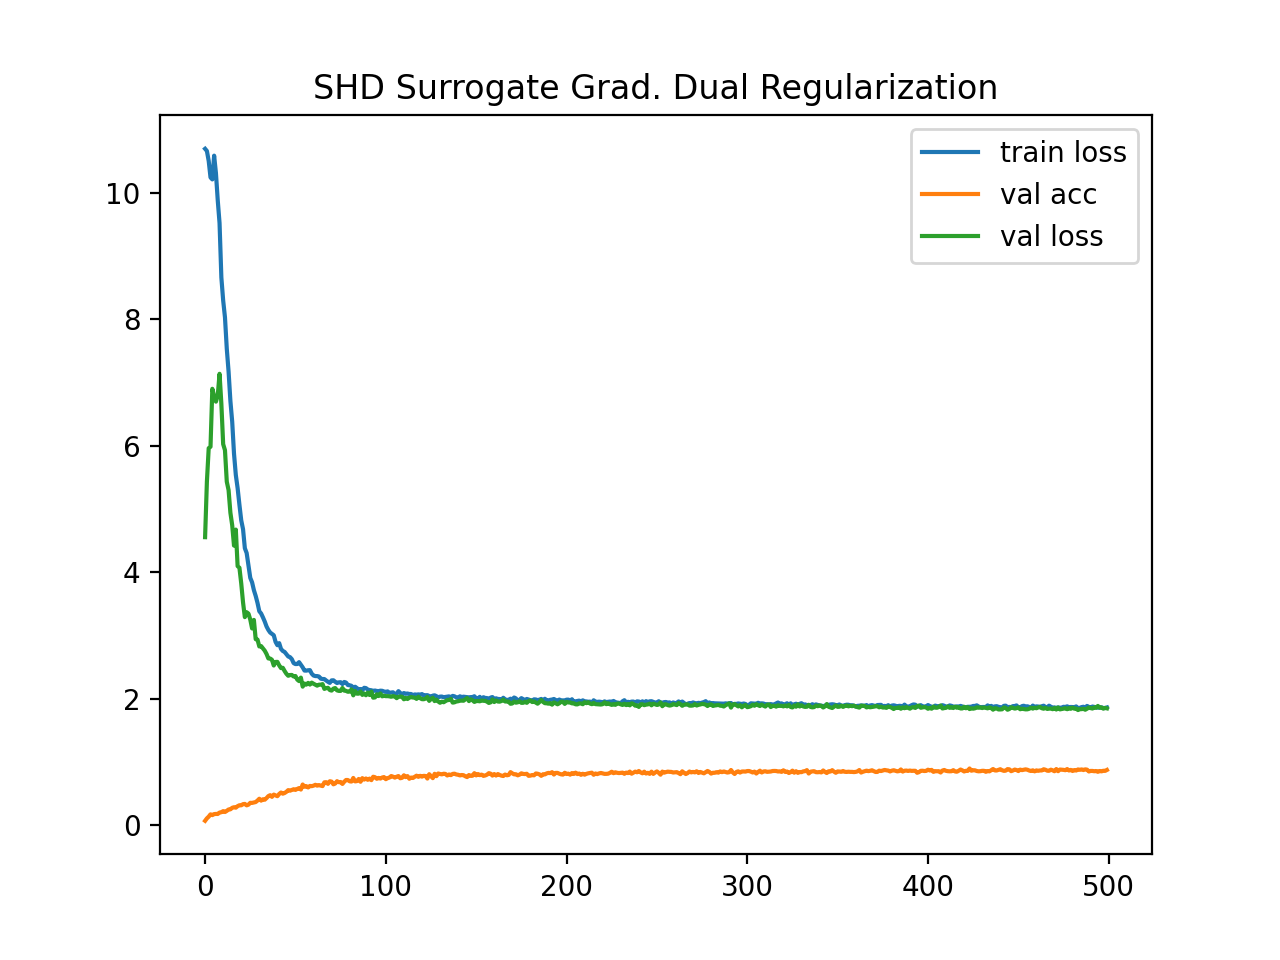

In [114]:
plt.plot(metrics, label=["train loss", "val acc", "val loss"])
plt.title("SHD Surrogate Grad. Dual Regularization")
plt.legend()
plt.show()

## Evaluation Time

Now we'll run the network on the test set and see what happens:

In [115]:
acc, loss, preds, tgts, spike_counts = test_gd(SNN, grad_params, shd_dl)
print("Accuracy:", acc, "Loss:", loss)

Accuracy: 0.7680664 Loss: 2.0215635


In [116]:
spike_counts.shape

(8, 256, 128)

In [118]:
jnp.mean(spike_counts[0], axis=0)

Array([ 4.527,  6.957,  3.426, 46.16 ,  3.5  ,  5.03 ,  3.781,  4.43 ,
       12.14 ,  7.043,  4.555,  9.95 , 14.484,  6.277,  9.16 ,  3.25 ,
        6.773,  8.39 ,  2.605, 28.39 , 13.34 , 12.4  ,  4.45 , 11.8  ,
        7.266, 17.34 , 18.47 , 28.62 ,  5.703,  6.63 , 31.9  ,  5.902,
        4.094,  2.105,  6.598, 27.34 ,  8.375, 12.266,  6.062,  7.133,
        5.55 ,  5.516,  7.508,  2.75 , 19.72 ,  8.64 ,  4.965,  4.49 ,
        4.363,  5.176,  4.133, 12.266, 11.05 , 47.5  ,  8.47 ,  3.8  ,
       26.53 ,  8.65 ,  4.24 ,  3.824,  6.543, 14.766,  7.53 , 11.42 ,
       24.11 , 13.56 ,  6.31 ,  7.566,  4.57 ,  8.25 , 10.02 ,  4.97 ,
       12.38 , 10.266,  3.469,  4.844, 12.59 ,  3.938, 17.34 ,  4.254,
       11.08 ,  9.914,  6.855,  6.95 ,  3.207,  5.258,  6.96 ,  6.5  ,
        6.32 ,  9.66 , 15.56 , 24.   , 15.97 ,  4.12 ,  5.67 ,  6.4  ,
       17.03 ,  3.3  , 53.75 ,  2.906,  5.977, 32.28 , 16.11 ,  6.656,
        8.375,  8.25 ,  3.723, 33.34 , 10.8  ,  4.812,  4.367, 30.77 ,
      

<IPython.core.display.Javascript object>


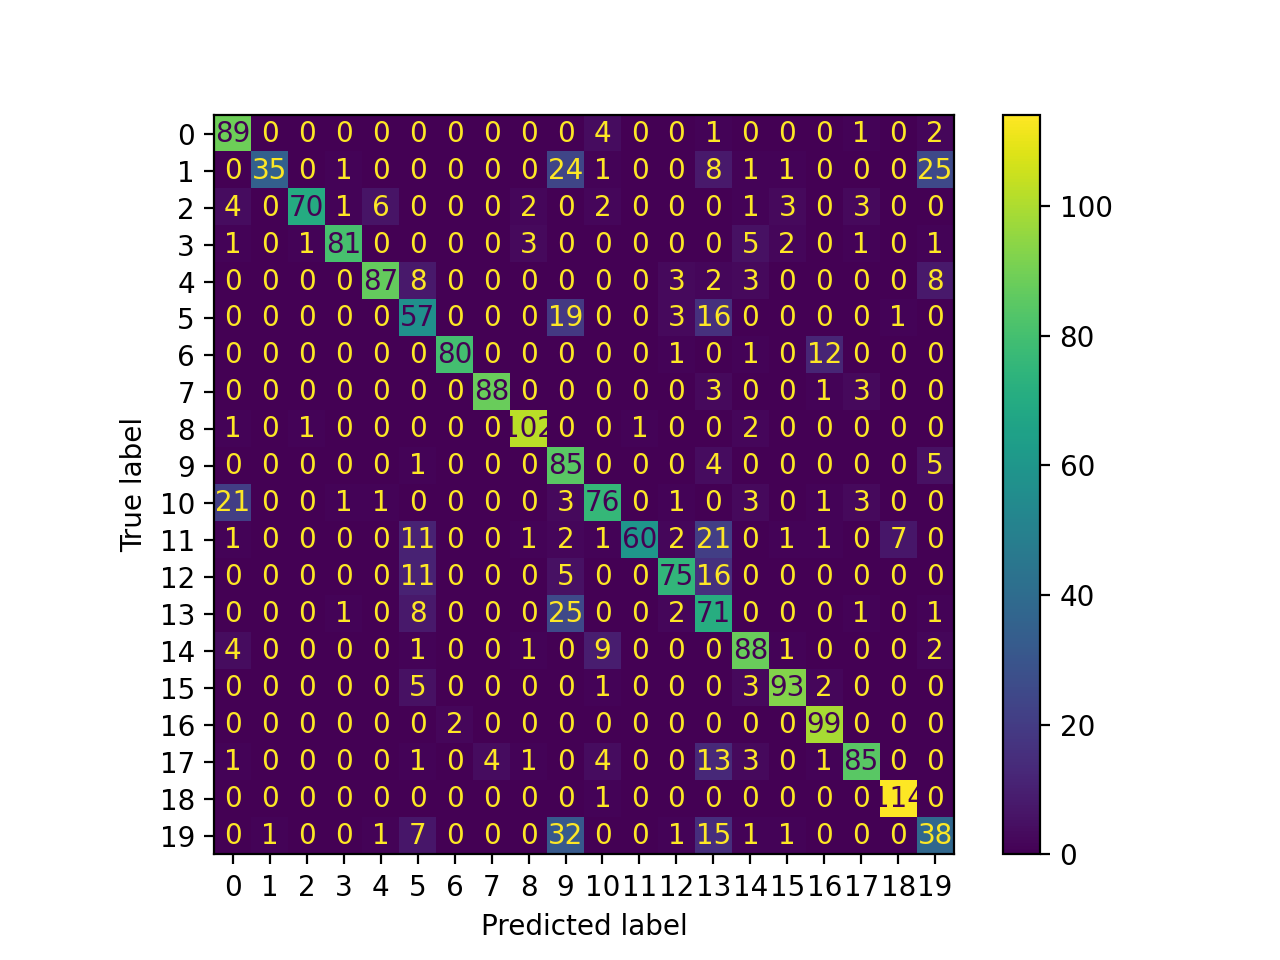

In [119]:
cm = confusion_matrix(tgts, preds)
ConfusionMatrixDisplay(cm).plot()
plt.show()